In [2]:
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

from tmv_app.utils.plotting import plot_tsne

# party positions in topic space (tsne)

In [3]:
run_id = 2350

save_dir = "./tsne_results/".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

stat = RunStats.objects.get(run_id=run_id)

#stat.dt_matrix(save_dir, force_overwrite=True)

In [4]:
perplexity = 10
# https://distill.pub/2016/misread-tsne/

#stat.dt_matrix(save_dir, force_overwrite=True)

tsne_results, r_ind = stat.calculate_tsne(save_dir, perplexity) #, force_overwrite=True)
tsne_results, r_ind

We've already calculated the required matrices!
We've already calculated the tsne positions


(array([[-17.65141262, -19.95958419],
        [-36.72234363, -15.13299024],
        [ 32.50572037,  36.99428651],
        ...,
        [-15.03923667,  13.06431606],
        [ 25.05107187,  12.02027767],
        [-22.97129277,   2.55042649]]),
 array([3342338, 2818065, 3211282, ..., 3112937, 2064374, 3309563]))

In [5]:
doctopicmatrix = np.load('tsne_results/run_2111_s_0_m.npy')
doctopicmatrix[()].toarray()

array([[8.33688388, 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       [0.01      , 8.03591896, 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       [0.01      , 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       ...,
       [0.01      , 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       [0.01      , 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       [0.01      , 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ]])

In [6]:
res = np.load('tsne_results/run_2111_s_0_p_10_results.npy')
res

array([[ 24.73900411,  34.97436381],
       [ 28.37862406, -27.31921759],
       [ 18.33316627,  21.65621293],
       ...,
       [ 37.15709386, -10.7031693 ],
       [-31.48692772,   6.35799802],
       [ -7.94024099,  40.60701861]])

In [7]:
# copied from max for category attribution

party_color_dict = {"afd": "#0088FF", "cducsu": "#000000", "fdp": "#FFED00", "gruene": "#64A12D",
                    "linke": "#8C3473", "spd": "#EB001F", "other": "grey"}

no_party_ids = r_ind

party_cats = [
    {'party': 'cducsu'},
    {'party': 'fdp'},
    {'party': 'gruene'},
    {'party': 'linke'},
    {'party': 'spd'},
]

#oecd_df = pd.DataFrame()

for i, c in enumerate(party_cats):
    party = c['party']
    uts = pm.Utterance.objects.filter(search_matches=stat.psearch, speaker__party__name=party).values_list('id', flat=True)
    c['docs'] = list(set(uts) & set(r_ind))
    #oecd_df = pd.concat([oecd_df,pd.DataFrame({
    #    "oecd": c['wc__oecd'], "doc": c['docs']
    #})])
    c['n_docs'] = len(c['docs'])
    c['name'] = party
    # assign color to the category
    c['color'] = party_color_dict[party]
    c['dis'] = np.argwhere(np.isin(r_ind,c['docs']))
    no_party_ids = no_party_ids[np.isin(no_party_ids,c['docs'],invert=True)]
    
from operator import itemgetter
party_cats = sorted(party_cats, key=itemgetter('n_docs'), reverse=True)


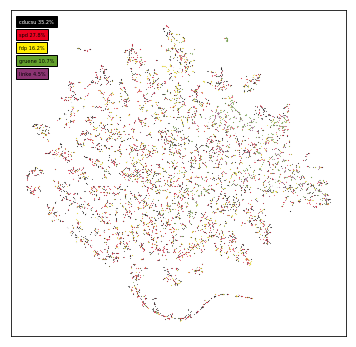

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_tsne(r_ind, tsne_results, party_cats, no_party_ids, ax=ax)
#ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

fig.savefig(os.path.join(save_dir, 'tsne_plot_parties_run_{}.png'.format(run_id)), dpi=150,
             bbox_inches="tight")

In [33]:
# color by parliamentary periods

cmap = plt.cm.viridis  # define the colormap: e.g. viridis or jet
norm = mpl.colors.Normalize(vmin=1.,vmax=19.)
# extract all colors from the .jet map
color_list = [cmap(norm(i)) for i in range(1,20)]

no_party_ids = r_ind

pp_cats = [{'period': i} for i in range(1, 20)]

for i, c in enumerate(pp_cats):
    pp = c['period']
    uts = pm.Utterance.objects.filter(search_matches=stat.psearch, document__parlperiod__n=pp).values_list('id', flat=True)
    c['docs'] = list(set(uts) & set(r_ind))
    c['n_docs'] = len(c['docs'])
    c['name'] = str(pp)
    # assign color to the category
    c['color'] = color_list[i]
    c['dis'] = np.argwhere(np.isin(r_ind,c['docs']))
    
from operator import itemgetter
pp_cats = sorted(pp_cats, key=itemgetter('n_docs'), reverse=True)

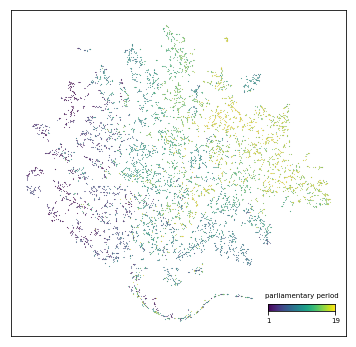

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(6, 6))
plot_tsne(r_ind, tsne_results, pp_cats, [], ax=ax, legend=False)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.arange(cmap.N))
axinset = inset_axes(ax, width="100%", height="100%",
            bbox_to_anchor=(.78, .05, .2, .1),
            bbox_transform=ax.transAxes)
axinset.set_xticks([0, 10])
axinset.set_xticklabels([1, 19])
axinset.set_yticks([])
axinset.imshow([colors], extent=[0, 10, 0, 1])
axinset.set_title('parliamentary period')

fig.savefig(os.path.join(save_dir, 'tsne_plot_parlperiods_run_{}.png'.format(run_id)), dpi=150, bbox_inches="tight")

<QuerySet [<Topic: economic policy>, <Topic: budget>, <Topic: climate protection>, <Topic: transport policy>, <Topic: subsidy reduction>, <Topic: tax policy>, <Topic: research & development>, <Topic: risks of nuclear energy>, <Topic: nuclear phase-out>, <Topic: reunification>, <Topic: coal mining>, <Topic: environmental protection>, <Topic: structural adjustment>, <Topic: green policies>, <Topic: European Coal and Steel Community>, <Topic: fiscal reform>, <Topic: economic policy 2>, <Topic: housing & social security>, <Topic: economic policy & participation>, <Topic: foreign policy>, '...(remaining elements truncated)...']>


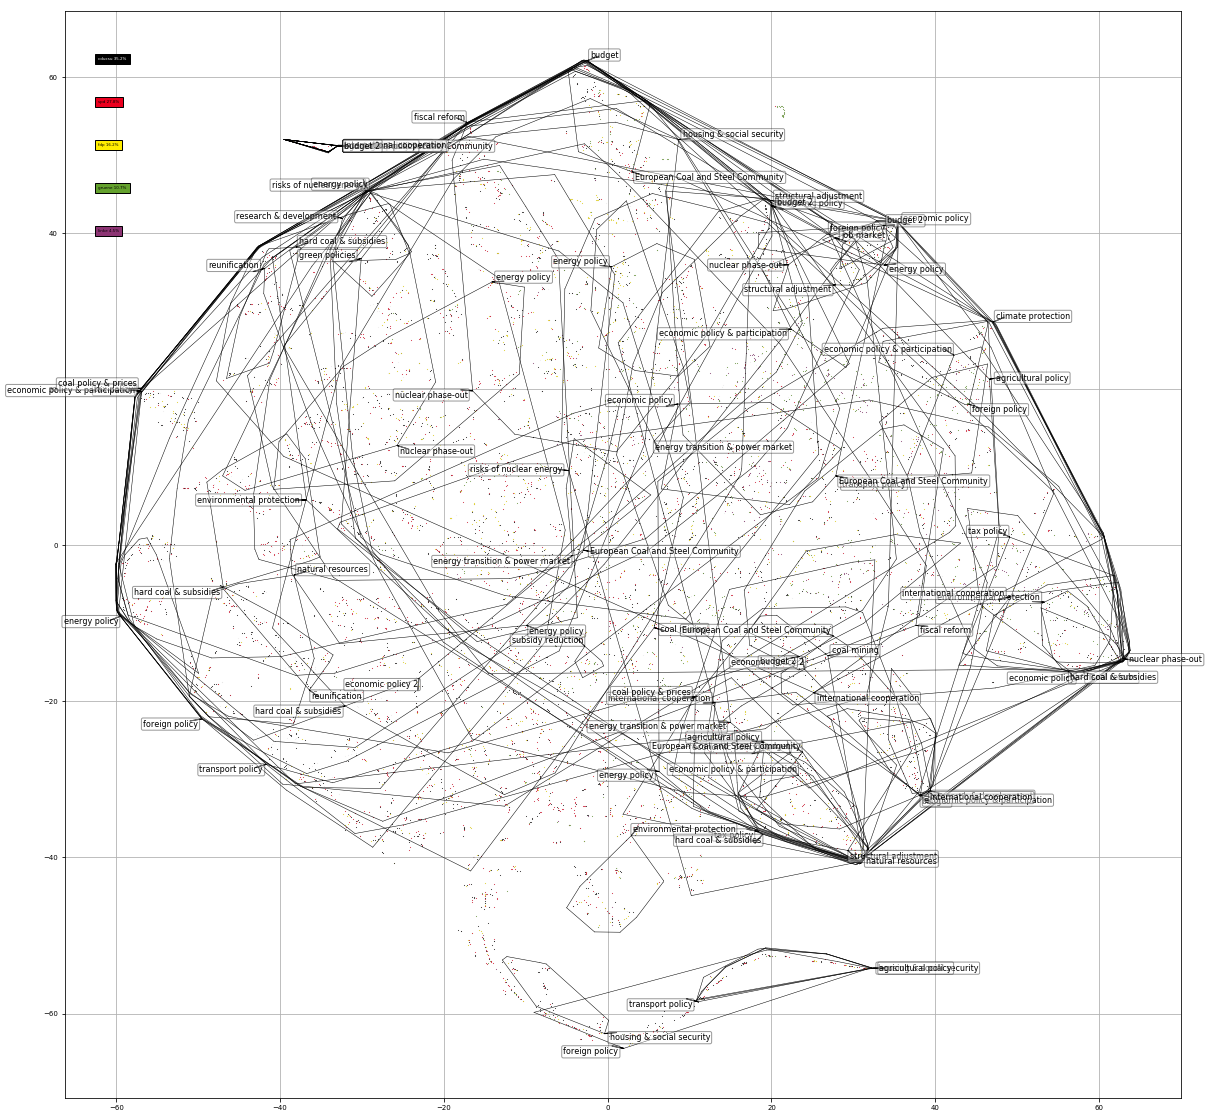

In [39]:
# with labels on clusters related to specific topics

fig, ax = plt.subplots(figsize=(20, 20))
topics = Topic.objects.filter(run_id=run_id)

wo_procedural = True

if wo_procedural:
    topic_dir = "plots/topic_analysis_{}/".format(run_id)
    topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
    procedural_topic_ids = topic_classification[topic_classification['classification'] == 'procedural and general politics'].index
    procedural_topic_ids = list(procedural_topic_ids)

    topics = topics.exclude(id__in=procedural_topic_ids)
    print(topics)

from time import time
import matplotlib.pyplot as plt
from time import time
import numpy as np
import random
import math
from scipy import interpolate
from matplotlib import cm, patches
from scoping.models import *
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from adjustText import adjust_text, get_renderer, get_bboxes

from utils.utils import flatten

def extend_points(p1,p2,length=0.8):
    p3 = [None,None]
    lenAB = np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    p3[0] = p2[0] + (p2[0] - p1[0]) / lenAB*length
    p3[1] = p2[1] + (p2[1] - p1[1]) / lenAB*length
    return p3

def cluster_label_points(
    title, points, ax, eps,
    min_cluster, n_clusters, clabel_size,
    words_only
    ):
    db = DBSCAN(eps=eps,min_samples=min_cluster).fit(points)
    labels = db.labels_
    texts = []
    bboxes = []
    r = get_renderer(ax.get_figure())
    for l in set(labels):
        text_set = False
        if l==-1:
            continue
        ind = np.argwhere(labels==l)[:,0]
        #print("\n##\nlabel: {}, {} documents".format(l,len(ind)))
        lpoints = points[ind]
        if len(ind) > min_cluster:
            try:
                hull = ConvexHull(lpoints)
            except:
                continue
            cx = np.mean(hull.points[hull.vertices,0])
            cy = np.mean(hull.points[hull.vertices,1])
            c = [cx,cy]


            if words_only:
                title = title.split(",")[0].replace("{","")

                text = ax.annotate(
                    title, c, fontsize=clabel_size,
                    ha="center",va="center",
                    bbox={'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round'}

                )
                texts.append(text)
                #return text
                #break

            else:
                for i, simplex in enumerate(hull.simplices):
                    p1 = extend_points(c,lpoints[simplex,:][0])
                    p2 = extend_points(c,lpoints[simplex,:][1])
                    plt.plot(
                        [p1[0],p2[0]],
                        [p1[1],p2[1]],
                        'k-',
                        linewidth=0.5
                    )
                    if not text_set:
                        if p1[0] > cx:
                            ha = "left"
                        else:
                            ha = "right"
                        pl = extend_points(c,p1)
                        texts.append(ax.annotate(
                            title,
                            p1,
                            xytext=pl,
                            va="center",
                            ha=ha,
                            fontsize=clabel_size,
                            arrowprops=dict(width=0.2,headwidth=0.1),
                            bbox={'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round'}
                        ))
                        text_set = True
                # break here, just do the biggest cluster
                #break
    return texts

def plot_tsne(
    r_ind,tsne_results,cats,nocatids,
    ax=None,verbose=False,hdoc=False,
    legend=True, sc=None, heat_var=None, cmapname=None,
    topics=None, min_cluster = 100, psize=1,
    t_thresh=0.8, eps=1, n_clusters=1,
    doc_sets=None, clabel_size=8,
    words_only=False, fsize=5, adjust=False,
    draw_highlight_points=False,
    dot_legend=False,
    nocat_colour='#F0F0F026',
    nocat_alpha=0.4
    ):
    cs = []
    sizes = []
    xs = []
    ys = []

    if ax == None:
        fig,ax = plt.subplots(dpi=188)
    t0 = time()

    nocatids = np.argwhere(np.isin(r_ind,nocatids))


    if hdoc is not False:
        hdocs = nocatids[np.isin(nocatids,hdoc)]
        ids = nocatids[np.isin(nocatids,hdoc,invert=True)]
    ax.scatter(
        tsne_results[nocatids,0],
        tsne_results[nocatids,1],
        c=nocat_colour,
        s=psize,
        alpha=nocat_alpha,
        linewidth=0.1,
        edgecolor='#a39c9c66'
    )

    # Draw docs to be highlighted separately
    if hdoc is not False:
        ax.scatter(
            tsne_results[hdocs,0],
            tsne_results[hdocs,1],
            c='#F0F0F026',
            s=psize,
            alpha=1,
            linewidth=0.5,
            edgecolor='black'
        )

    # split the data and add layer by layer to prevent top layer overwriting all
    splits = 10
    for i in range(splits):
        for c in cats:
            ids = np.array_split(c["dis"],splits)[i]
            if hdoc is not False:
                hdocs = ids[np.isin(ids,hdoc)]
                ids = ids[np.isin(ids,hdoc,invert=True)]

            if len(nocatids) > len(r_ind) / 2:
                a = 1
            else:
                a = 0.7
            ax.scatter(
                tsne_results[ids,0],
                tsne_results[ids,1],
                #zorder = [math.ceil(random.random()*1) for i in range(len(ids))],
                c=c['color'],
                s=psize,
                alpha=a,
                linewidth=0.1,
                edgecolor='#a39c9c66'
            )
            if hdoc is not False:
                ax.scatter(
                    tsne_results[hdocs,0],
                    tsne_results[hdocs,1],
                    c=c["color"],
                    s=psize,
                    alpha=1,
                    linewidth=0.5,
                    edgecolor='black'
                )



    ax.grid(linestyle='-')

    if verbose:
        print("calculating points took %0.3fs." % (time() - t0))

    l = ax.get_xlim()[0]
    t = ax.get_ylim()[1]

    yextent = ax.get_ylim()[1]- ax.get_ylim()[0]
    ysp = yextent*0.04


    if legend:
        for i,c in enumerate(cats):
            prop = len(c['docs'])/len(r_ind)
            label = "{} {:.1%}".format(c['name'],prop)
            if dot_legend:
                if prop>0.001:
                    ax.scatter(
                        [],[],c=c['color'],label=label
                    )
            else:
                if c['color'] == "#000000":
                    tcolor="white"
                else:
                    tcolor="black"
                ax.text(
                    l*0.95,
                    t-ysp-i*ysp,
                    label,
                    fontsize=fsize,
                    color=tcolor,
                    bbox={
                        'facecolor': c['color'],
                        'pad': 3
                    }
                )

    if dot_legend:
        ax.legend()

    if heat_var:
        cmap = cm.get_cmap(cmapname)
        ys = [getattr(cs,heat_var) for cs in sc.objects if getattr(cs,heat_var) is not None]
        X = np.interp(ys, (np.min(ys), np.max(ys)), (0, +1))
        f = interpolate.interp1d(ys, X)
        for cs in sc.objects:
            if getattr(cs, heat_var):
                col = cmap(f(getattr(cs, heat_var)).max())
                rect = patches.Rectangle(
                    (cs.x1,cs.y1),cs.x2-cs.x1,cs.y2-cs.y1,
                    linewidth=1,edgecolor='r',
                    facecolor=col,alpha=0.3
                )

                ax.add_patch(rect)

    if topics:
        texts = []
        for t in topics:
            if t.run_id.method=="DT":
                atdocscores = Utterance.objects.filter(
                    docdynamictopic__topic=t,
                ).values_list('docdynamictopic__score',flat=True)
                
                print(atdocscores)

                thresh = np.quantile(atdocscores,t_thresh)

                tdocs = Utterance.objects.filter(
                    docdynamictopic__topic=t,
                    docdynamictopic__score__gt=thresh
                ).order_by('-docdynamictopic__score').values_list('id',flat=True)
            else:
                atdocscores = pm.Utterance.objects.filter(
                    doctopic__topic=t,
                ).values_list('doctopic__score',flat=True)

                thresh = np.quantile(atdocscores,t_thresh)
                
                tdocs = pm.Utterance.objects.filter(
                    doctopic__topic=t,
                    doctopic__score__gt=thresh
                ).order_by('-doctopic__score').values_list('id',flat=True)
                
            highlight_docs = np.argwhere(np.isin(r_ind,tdocs))[:,0]
            

            if len(highlight_docs) == 0:
                continue

            points = tsne_results[highlight_docs]

            texts.append(cluster_label_points(
                t.title,
                points,
                ax,
                eps,
                min_cluster,
                n_clusters,
                clabel_size,
                words_only
            ))

            if draw_highlight_points:
                ax.scatter(
                    points[:,0],
                    points[:,1],
                    c=c["color"],
                    s=psize,
                    alpha=1,
                    linewidth=0.5,
                    edgecolor='black'
                )

        if adjust:
            texts = list(flatten(texts))
            adjust_text(texts,ax=ax, arrowprops=dict(arrowstyle="->", color='None', lw=0.5))

    if doc_sets:
        for d in doc_sets:
            highlight_docs = np.argwhere(np.isin(r_ind,d['docs']))[:,0]
            points = tsne_results[highlight_docs]

            cluster_label_points(
                d['title'],
                points,
                ax,
                eps,
                min_cluster,
                n_clusters,
                clabel_size
            )


plot_tsne(r_ind, tsne_results, party_cats, no_party_ids, ax=ax, topics=topics,
          min_cluster=10, # minimum number of documents in cluster
          eps=8, # maximal distance between documents in cluster
          words_only=False, # draw boundaries of clusters if False
          t_thresh=0.9, # which quantiles to look at
          fsize=4 # font size for labels
         )

In [ ]:
# test how many clusters there are

t = topics[0]
t_thresh=0.9

atdocscores = pm.Utterance.objects.filter(
    doctopic__topic=t,
).values_list('doctopic__score',flat=True)

thresh = np.quantile(atdocscores,t_thresh)

tdocs = pm.Utterance.objects.filter(
    doctopic__topic=t,
    doctopic__score__gt=thresh
).order_by('-doctopic__score').values_list('id',flat=True)

highlight_docs = np.argwhere(np.isin(r_ind,tdocs))[:,0]
points = tsne_results[highlight_docs]
db = DBSCAN(eps=8,min_samples=10).fit(points)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

d = pd.DataFrame({"a":labels})
d['a'].value_counts()

# compress folder to easily download it

In [ ]:
%%bash
zip -r plots/topic_analysis_2111.zip plots/topic_analysis_2111/